#KODE HOOK OFDM based on standard 7A - Transmitter,

Kode dengan tambahan bit 0 dibelakang, jumalh OOK = 38+2, ofdm = 192+8

kode ini sudah ditambah dengan realtime sistem


# OFDM Transmitter side ~~~~~~ KODE yg full

#Transmitter Block Diagram

In [3]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import reedsolo


#Block diagram Input data (ASCII->BINARY)

In [4]:
def string_to_bits(s):
    """Convert a string to a list of bits."""
    return list(itertools.chain.from_iterable([list(map(int, f"{ord(c):08b}")) for c in s]))

def binary_to_bytes(binary_str):
    """Convert a binary string to bytes."""
    byte_array = bytearray()
    for i in range(0, len(binary_str), 8):
        byte_array.append(int(binary_str[i:i+8], 2))
    return bytes(byte_array)

def bytes_to_binary(byte_array):
    """Convert bytes to a binary string."""
    return ''.join(f'{byte:08b}' for byte in byte_array)

print()

#Block Diagram QAM

In [5]:
def binary_to_qam16(bits):
    """Convert a binary list to QAM-16 symbols."""
    M = 4  # QAM-16
    #M = 16  # QAM-16
    bits_per_symbol = int(np.log2(M))  # 4 bits per QAM-16 symbol
    # Ensure the stream length is a multiple of bits_per_symbol (4 for QAM-16)
    pad_length = (bits_per_symbol - len(bits) % bits_per_symbol) % bits_per_symbol
    padded_bits = np.append(bits, [0] * pad_length)
    # # QAM-16 mapping
    # mapping = {
    #     '0000': -3-3j, '0001': -3-1j, '0010': -3+3j, '0011': -3+1j,
    #     '0100': -1-3j, '0101': -1-1j, '0110': -1+3j, '0111': -1+1j,
    #     '1000':  3-3j, '1001':  3-1j, '1010':  3+3j, '1011':  3+1j,
    #     '1100':  1-3j, '1101':  1-1j, '1110':  1+3j, '1111':  1+1j
    # }
    mapping = {
        '00':  1+1j,  # Symbol 1
        '01':  1-1j,  # Symbol 2
        '11': -1-1j,  # Symbol 3
        '10': -1+1j   # Symbol 4
    }
    symbols = []
    # Convert each group of 4 bits to a QAM-16 symbol
    for i in range(0, len(padded_bits), bits_per_symbol):
        bit_group = ''.join(str(int(bit)) for bit in padded_bits[i:i+bits_per_symbol])
        symbols.append(mapping[bit_group])
    return np.array(symbols)


#Blok Diagram Hermitian Mapping

In [6]:
def hermitian_symmetry(symbols):
    """Apply Hermitian symmetry to generate a 16-subcarrier OFDM symbol."""
    N = 16  # Number of subcarriers
    hermitian_symmetric = np.zeros(N, dtype=complex)  # Initialize the output array
    
    # Assign QAM symbols to the subcarriers according to the specified order
    hermitian_symmetric[1:8] = symbols[0:7]  # Subcarrier 2 to 8
    hermitian_symmetric[8] = 0  # Nyquist frequency (Subcarrier 9) is set to 0
    hermitian_symmetric[9] = np.conj(symbols[6])  # Subcarrier 10 is the conjugate of Subcarrier 8
    hermitian_symmetric[10:15] = np.conj(symbols[1:6])[::-1]  # Subcarrier 11 to 15 are conjugate and reversed
    hermitian_symmetric[15] = np.conj(symbols[0])  # Subcarrier 16 is the conjugate of Subcarrier 2

    return hermitian_symmetric

#Block Diagram IDFT

In [7]:
def create_ofdm_symbols(qam_symbols, num_subcarriers=16, symbols_per_ofdm=7):
    """Create OFDM symbols with Hermitian symmetry."""
    num_ofdm_symbols = len(qam_symbols) // symbols_per_ofdm  # Number of OFDM symbols
    ofdm_symbols = []  # List to hold the time-domain OFDM symbols
    
    for i in range(num_ofdm_symbols):
        # Extract the relevant QAM symbols for this OFDM symbol
        start_idx = i * symbols_per_ofdm
        end_idx = start_idx + symbols_per_ofdm
        qam_chunk = qam_symbols[start_idx:end_idx]
        
        # Apply Hermitian symmetry to create the frequency-domain sequence
        hermitian_symmetric_seq = hermitian_symmetry(qam_chunk)
        # Print the time-domain OFDM symbols
        print("hermitian_symmetric_seq Symbols:")
        print(hermitian_symmetric_seq)
        # Perform IFFT to get the time-domain OFDM symbol
        time_domain_ofdm = np.fft.ifft(hermitian_symmetric_seq)
        # Append the time-domain OFDM symbol to the list
        ofdm_symbols.append(time_domain_ofdm)
        
    
    return np.array(ofdm_symbols)  # Convert list to a NumPy array

#Data INPUT

In [8]:
# input data min 17, 33, 49, 65 (kelipatan 16), karena hermitian 15,11
data = "KookminUniversity"
print("Data input :", data)
character_count = len(data)
print (f"len of data: {character_count}")
bits = string_to_bits(data)
print("tx bits: ", bits)
binary_str = ''.join(map(str, bits))
print(f"Transmitted Signal: {list(binary_str)}")
data_bytes = binary_to_bytes(binary_str)
print(data_bytes)

Data input : KookminUniversity
len of data: 17
tx bits:  [0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1]
Transmitted Signal: ['0', '1', '0', '0', '1', '0', '1', '1', '0', '1', '1', '0', '1', '1', '1', '1', '0', '1', '1', '0', '1', '1', '1', '1', '0', '1', '1', '0', '1', '0', '1', '1', '0', '1', '1', '0', '1', '1', '0', '1', '0', '1', '1', '0', '1', '0', '0', '1', '0', '1', '1', '0', '1', '1', '1', '0', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '1', '0', '1', '1', '1', '0', '0', '1', '1', '0', '1', '0', '0', '1', '0', '1', '1', '1', '0', '1', '1', '0', '0', '1', '1', '0', '0', '1', '0', '1', '0', '1', '1', '1', '0', '0', '1'

#Block diagram Reed-Solomon code

In [9]:
# Initialize the Reed-Solomon code
# Encoding the data BY rs(15,11) 2 BIT error corrections
n = 15
k = 11
rs = reedsolo.RSCodec(n - k)

encoded_data = rs.encode(data_bytes)
# Convert the encoded bytes back to binary
encoded_binary = bytes_to_binary(encoded_data)
print(f"FEC Encoded binary data (15,11): {encoded_binary}")
# Convert the binary string to a list of integers
binary_list = [int(bit) for bit in encoded_binary]
print(binary_list)


FEC Encoded binary data (15,11): 010010110110111101101111011010110110110101101001011011100101010101101110011010010111011001100101011100100111001101101001011101000111100101100001110110000101011010000001
[0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1]


#QAM + Hermitian + OFDM 

In [10]:
# Step 4: QAM Modulation for each parallel stream
qam_symbols = binary_to_qam16(binary_list)
print(f"QAM Symbols (one row per subcarrier):{qam_symbols}")
# Create OFDM symbols
ofdm_symbols = create_ofdm_symbols(qam_symbols)
# Print the time-domain OFDM symbols
print("Time-Domain OFDM Symbols:")
print(ofdm_symbols)
tx_signal_combined_real = np.concatenate([ofdm.real for ofdm in ofdm_symbols])
print("combine real of ofdm", tx_signal_combined_real)


QAM Symbols (one row per subcarrier):[ 1.-1.j  1.+1.j -1.+1.j -1.-1.j  1.-1.j -1.+1.j -1.-1.j -1.-1.j  1.-1.j
 -1.+1.j -1.-1.j -1.-1.j  1.-1.j -1.+1.j -1.+1.j -1.-1.j  1.-1.j -1.+1.j
 -1.-1.j  1.-1.j  1.-1.j -1.+1.j -1.+1.j  1.-1.j  1.-1.j -1.+1.j -1.-1.j
 -1.+1.j  1.-1.j  1.-1.j  1.-1.j  1.-1.j  1.-1.j -1.+1.j -1.-1.j -1.+1.j
  1.-1.j -1.+1.j -1.+1.j  1.-1.j  1.-1.j -1.-1.j  1.-1.j -1.+1.j  1.-1.j
 -1.+1.j  1.-1.j  1.-1.j  1.-1.j -1.-1.j  1.+1.j -1.+1.j  1.-1.j -1.-1.j
  1.+1.j -1.-1.j  1.-1.j -1.+1.j -1.+1.j  1.-1.j  1.-1.j -1.-1.j  1.-1.j
  1.+1.j  1.-1.j -1.-1.j -1.+1.j  1.-1.j  1.-1.j -1.+1.j  1.+1.j  1.-1.j
 -1.-1.j  1.-1.j -1.+1.j  1.+1.j  1.-1.j  1.-1.j  1.-1.j -1.+1.j -1.+1.j
  1.+1.j  1.+1.j  1.-1.j]
hermitian_symmetric_seq Symbols:
[ 0.+0.j  1.-1.j  1.+1.j -1.+1.j -1.-1.j  1.-1.j -1.+1.j -1.-1.j  0.+0.j
 -1.+1.j -1.-1.j  1.+1.j -1.+1.j -1.-1.j  1.-1.j  1.+1.j]
hermitian_symmetric_seq Symbols:
[ 0.+0.j -1.-1.j  1.-1.j -1.+1.j -1.-1.j -1.-1.j  1.-1.j -1.+1.j  0.+0.j
 -1.-1.j  

#Plotting Figure

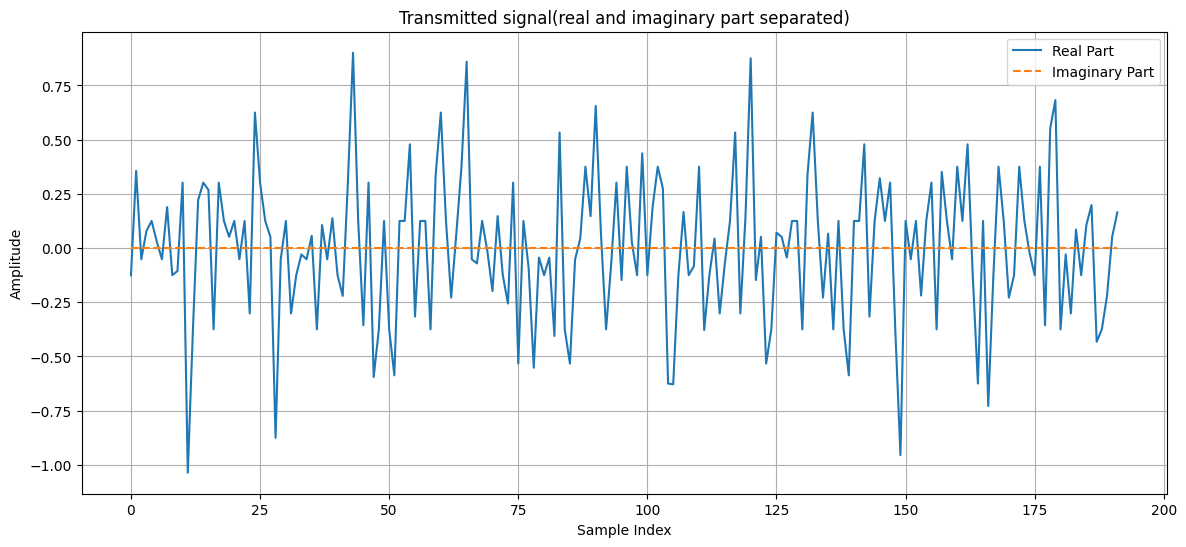

In [11]:
def plot_ofdm_symbols(ofdm_symbols):
    """Plot the real and imaginary parts of all time-domain OFDM symbols in a single graph."""
    combined_real = np.concatenate([ofdm.real for ofdm in ofdm_symbols])
    combined_imag = np.concatenate([ofdm.imag for ofdm in ofdm_symbols])

    plt.figure(figsize=(14, 6))

    plt.plot(combined_real, label='Real Part')
    plt.plot(combined_imag, label='Imaginary Part', linestyle='--')
    plt.title('Transmitted signal(real and imaginary part separated)')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_ofdm_symbols(ofdm_symbols)
# print("asdasd",ofdm_symbols)

#Signal Clipping

In [12]:
# Function to implement the clipping of the biased signal
def clip_signal(x_t):
    alpha = 0.5  #0.5, 1, 1.5
    percentile_value = 85 #85
    # Step 1: Calculate b = α ⋅ σ(x(t))
    sigma_x_t = np.std(x_t)
    b = alpha * sigma_x_t
    # Apply bias to the signal
    biased_signal = (x_t + b)*20 # scaling factor 5
    # Step 2: Calculate A = P_percentile(x_biased(t))
    A = np.percentile(biased_signal, percentile_value)
    # Step 3: Apply clipping
    clipped_signal = np.clip(biased_signal, 0, A)
    return clipped_signal

# Apply the clipping function
clipped_signal_OFDM = clip_signal(tx_signal_combined_real)
clipped_signal_OFDM = np.array([clipped_signal_OFDM])
print ("clipping ofdm",clipped_signal_OFDM)
#Pure OFDM   ---------------------------------------------------------- 
transmitted_signal = clipped_signal_OFDM
normalized_signal = np.round(transmitted_signal).astype(int).reshape(-1)
print(f"Normalized Signal Length: {len(normalized_signal)}")

#Output Pure_OFDM value -----------------------------------------------
OFDM_signal = normalized_signal  # this data is pure frequency data
print ("Pure OFDM", OFDM_signal)
OFDM_signal = ', '.join(map(str, normalized_signal))
# print(f"Normalized Signal (Pure OFDM) = [{OFDM_signal}]")
# Data_OFDM_signal = print(f"Normalized Signal (Pure OFDM) = [{OFDM_signal}]")
# print("sadasd", Data_OFDM_signal)

#---------------- Kode dibawah bertujuan untuk dimasukkan datanya kedalam mapping data
Data_ofdm = OFDM_signal
Data_ofdm = list(map(int, Data_ofdm.split(',')))  # Konversi menjadi list of int
print ("\nPure OFDM for adding 0:", Data_ofdm)
min_value = np.min(normalized_signal)
max_value = np.max(normalized_signal)
print(f"Minimum value: {min_value}")
print(f"Maximum value: {max_value}\n")
# plot_ofdm_symbols(normalized_signal)

# plt.figure(figsize=(10, 6))
# plt.plot(Data_ofdm, marker='o', linestyle='-', color='b', label='OFDM Signal')
# plt.plot(normalized_signal, marker='v', linestyle='-', color='r', label='OFDM Signal')
# plt.title('Pure OFDm Signa Without Adding bias')
# plt.xlabel('Sample Index')
# plt.ylabel('Amplitude')
# plt.grid(True)
# plt.legend()
# plt.show()

clipping ofdm [[0.80718914 9.4869094  2.27165523 4.88833381 5.80718914 3.89377198
  2.27165523 7.08569361 0.80718914 1.18779148 9.34272304 0.
  0.         7.7206063  9.34272304 8.67082029 0.         9.34272304
  5.80718914 4.34272304 5.80718914 2.27165523 5.80718914 0.
  9.4869094  9.34272304 5.80718914 4.34272304 0.         2.27165523
  5.80718914 0.         0.80718914 2.7206063  2.27165523 4.43202496
  0.         5.4265868  2.27165523 6.06149949 0.80718914 0.
  9.34272304 9.4869094  5.80718914 0.         9.34272304 0.
  0.         5.80718914 0.         0.         5.80718914 5.80718914
  9.4869094  0.         5.80718914 5.80718914 0.         9.4869094
  9.4869094  5.80718914 0.         4.63402346 9.4869094  9.4869094
  2.27165523 1.8910529  5.80718914 3.06421857 0.         6.25614021
  0.80718914 0.         9.34272304 0.         5.80718914 1.47909189
  0.         2.42930588 0.80718914 2.42930588 0.         9.4869094
  0.         0.         2.27165523 4.18507239 9.4869094  6.25614021
 

#Kode ini digunakan untuk menambahkan "0" pada pure data ofdm.
    #karena total data ada 192 + 8 = 200, OOK bit ada 40, jadi 200/40 = 5 bit ofdm dalam 1 ook
    #karena sebelumnya, data 192, langsung di mapping 192/38 = 190. sisa 2, dihapus dan hal ini bisa jadi BER pada OFDM

In [13]:
print("Pure OFDM     = ", Data_ofdm)
print(f"Normalized Signal Length Before: {len(normalized_signal)}")

max_length = 200
# Tambahkan 0 hingga panjang array mencapai max_length
Data_ofdm.extend([0] * (max_length - len(Data_ofdm)))

# Tampilkan panjang array yang telah dimodifikasi
# print(f"Normalized Signal = {normalized_signal}")
print(f"\nPure OFDM+0*8 = {Data_ofdm}")
print(f"Normalized Signal Length Afterr: {len(Data_ofdm)}")

Pure OFDM     =  [1, 9, 2, 5, 6, 4, 2, 7, 1, 1, 9, 0, 0, 8, 9, 9, 0, 9, 6, 4, 6, 2, 6, 0, 9, 9, 6, 4, 0, 2, 6, 0, 1, 3, 2, 4, 0, 5, 2, 6, 1, 0, 9, 9, 6, 0, 9, 0, 0, 6, 0, 0, 6, 6, 9, 0, 6, 6, 0, 9, 9, 6, 0, 5, 9, 9, 2, 2, 6, 3, 0, 6, 1, 0, 9, 0, 6, 1, 0, 2, 1, 2, 0, 9, 0, 0, 2, 4, 9, 6, 9, 5, 0, 2, 9, 0, 9, 4, 1, 9, 1, 7, 9, 9, 0, 0, 1, 7, 1, 2, 9, 0, 1, 4, 0, 2, 6, 9, 0, 6, 9, 0, 4, 0, 0, 5, 4, 2, 6, 6, 0, 9, 9, 6, 0, 5, 0, 6, 0, 0, 6, 6, 9, 0, 6, 9, 6, 9, 0, 0, 6, 2, 6, 0, 6, 9, 0, 9, 6, 2, 9, 6, 9, 1, 0, 6, 0, 1, 9, 6, 0, 1, 9, 6, 3, 1, 9, 0, 9, 9, 0, 3, 0, 5, 1, 5, 7, 0, 0, 0, 4, 7]
Normalized Signal Length Before: 192

Pure OFDM+0*8 = [1, 9, 2, 5, 6, 4, 2, 7, 1, 1, 9, 0, 0, 8, 9, 9, 0, 9, 6, 4, 6, 2, 6, 0, 9, 9, 6, 4, 0, 2, 6, 0, 1, 3, 2, 4, 0, 5, 2, 6, 1, 0, 9, 9, 6, 0, 9, 0, 0, 6, 0, 0, 6, 6, 9, 0, 6, 6, 0, 9, 9, 6, 0, 5, 9, 9, 2, 2, 6, 3, 0, 6, 1, 0, 9, 0, 6, 1, 0, 2, 1, 2, 0, 9, 0, 0, 2, 4, 9, 6, 9, 5, 0, 2, 9, 0, 9, 4, 1, 9, 1, 7, 9, 9, 0, 0, 1, 7, 1, 2, 9, 0, 1, 4, 0, 2, 6, 

#Signal Deviding by low and high frequency

In [14]:
# #1st Mapping Frequency in low and Higher Frequency (example)

# #Next Mapping OFDM _ for High frequency
# transmitted_signal1 = clipped_signal_OFDM + 200
# normalized_signal1 = np.round(transmitted_signal1).astype(int).reshape(-1)
# # print(f"Normalized Signal = {normalized_signal1}")
# print(f"Normalized Signal Length: {len(normalized_signal1)}")
# #Add bias to handling noise -------------------- high frequency
# OFDM_signal_High = normalized_signal1  # this data is pure frequency data
# # print ("Add high bias OFDM", OFDM_signal_High)
# OFDM_signal_High = ', '.join(map(str, normalized_signal1))
# print(f"Normalized Signal+ adding high bias = [{OFDM_signal_High}]")
# min_value = np.min(normalized_signal1)
# max_value = np.max(normalized_signal1)
# print(f"Minimum value: {min_value}")
# print(f"Maximum value: {max_value}\n")

# ########################################################################################

# #Next Mapping OFDM _ for Low frequency
# transmitted_signal2 = clipped_signal_OFDM + 50
# normalized_signal2 = np.round(transmitted_signal2).astype(int).reshape(-1)
# # print(f"Normalized Signal = {normalized_signal2}")
# print(f"Normalized Signal Length: {len(normalized_signal2)}")
# #add bias to handling noise -------------------- low frequency
# OFDM_signal_Low = normalized_signal2  # this data is pure frequency data
# # print ("Add low bias OFDM", OFDM_signal_Low)
# OFDM_signal_Low = ', '.join(map(str, normalized_signal2))
# print(f"Normalized Signal+ adding low bias= [{OFDM_signal_Low}]")
# min_value = np.min(normalized_signal2)
# max_value = np.max(normalized_signal2)
# print(f"Minimum value: {min_value}")
# print(f"Maximum value: {max_value}")

# ########################################################################################
# #Mapping value
# plt.figure(figsize=(10, 6))
# plt.plot(normalized_signal1, marker='^', linestyle='-', color='b', label='High Freq Value')
# plt.plot(normalized_signal2, marker='v', linestyle='-', color='r', label='Low Freq Value')
# plt.title('Signal mapping- Low and High Frequency')
# plt.xlabel('Sample Index')
# plt.ylabel('Amplitude')
# plt.grid(True)
# plt.legend()
# plt.show()


In [15]:
# #2nd MAPPING to handle the noise ------------ (example)

# #high frequency mapping
# high_mapping = {200: 153, 201: 161, 202: 169, 203: 177, 204:185,
#                  205: 193, 206: 201, 207: 209, 208: 217, 209:225}
# high_mapped_values = [high_mapping.get(value, None) for value in normalized_signal1]
# print(f"high_mapped_values = {high_mapped_values}")
# high_length_of_data = len(high_mapped_values)
# print(f"length_of_data: {high_length_of_data}\n")


# #low frequency mapping
# low_mapping = {70: 73, 71: 81, 72: 84, 73: 97, 74: 105,
#            75: 113, 76: 121, 77: 129, 78: 137, 79:145}

# low_mapped_values = [low_mapping.get(value, None) for value in normalized_signal2]
# print(f"low_mapped_values = {low_mapped_values}")
# low_length_of_data = len(low_mapped_values)
# print(f"length_of_data: {low_length_of_data}")


# plt.figure(figsize=(10, 6))
# plt.plot(high_mapped_values, marker='^', linestyle='-', color='b', label='High Freq Value')
# plt.plot(low_mapped_values, marker='v', linestyle='-', color='r', label='Low Freq Value')
# plt.title('Signal mapping for Real implementation- Low and High Frequency')
# plt.xlabel('Sample Index')
# plt.ylabel('Amplitude')
# plt.grid(True)
# plt.legend()
# plt.show()



# OOK Modulation

In [16]:
## Hamming 16 bit -Transmitter " Standard 7a"
import numpy as np
input_data = "4"
print("input data: Drone number", input_data)
# 1. Convert Teks ke Biner (Bit Stream)
def text_to_bits(text):
    return ''.join(format(ord(char), '08b') for char in text)

def hamming_encoder(data_bits):
    encoded_bits = []
    for i in range(0, len(data_bits), 4):
        # Ambil 4 bit data
        data = data_bits[i:i+4]
        
        # Hitung bit paritas
        p1 = (int(data[0]) + int(data[1]) + int(data[3])) % 2  # p1 = d1 + d2 + d4
        p2 = (int(data[0]) + int(data[2]) + int(data[3])) % 2  # p2 = d1 + d3 + d4
        p3 = (int(data[1]) + int(data[2]) + int(data[3])) % 2  # p3 = d2 + d3 + d4
        p4 = (p1 + p2 + int(data[0]) + p3 + int(data[1]) + int(data[2]) + int(data[3])) % 2  # p4 = p1 + p2 + d1 + p3 + d2 + d3 + d4
        
        # Gabungkan dalam urutan Hamming (8,4): p1, p2, d1, p3, d2, d3, d4, p4
        encoded_bits.append(str(p1) + str(p2) + data[0] + str(p3) + data[1] + data[2] + data[3] + str(p4))
    
    return ''.join(encoded_bits)

# 3. RLL Encoder (Manchester)
def manchester_encoding(data_bits):
    manchester_bits = []
    for bit in data_bits:
        if bit == '1':
            manchester_bits.append('10')  # Manchester encoding untuk 1
        else:
            manchester_bits.append('01')  # Manchester encoding untuk 0
    return ''.join(manchester_bits)

# 4. Low Rate Preamble (6 bit)
def add_preamble(encoded_bits, preamble="10101010"):
    return preamble + encoded_bits

# 5. OOK Modulation
def ook_modulation(data_bits):
    # OOK: 1 -> ON, 0 -> OFF
    return [1 if bit == '1' else 0 for bit in data_bits]

# Main Transmitter Function
def transmitter(input_data):
    # Step 1: Convert Teks ke Biner (Bit Stream)
    bit_stream = text_to_bits(input_data)
    print(f"Bit Stream: {bit_stream}")
    
    # Step 2: FEC Encoding (Hamming 8,4)
    encoded_bits = hamming_encoder(bit_stream)
    print(f"Encoded Bits (Hamming 8,4): {encoded_bits}")
    
    # Step 3: RLL Encoding (Manchester)
    manchester_bits = manchester_encoding(encoded_bits)
    print(f"Manchester Encoded Bits: {manchester_bits}")
    
    # Step 4: Add Low Rate Preamble (6-bit)
    preambled_bits = add_preamble(manchester_bits)
    print(f"Bits with Preamble: {preambled_bits}")
    
    # Step 5: OOK Modulation
    OOK_signal = ook_modulation(preambled_bits)
    print(f"OOK Modulated Signal: {OOK_signal}")
    
    return OOK_signal


OOK_signal = transmitter(input_data)
print ("Asdas                ", OOK_signal)


input data: Drone number 4
Bit Stream: 00110100
Encoded Bits (Hamming 8,4): 1000011110011001
Manchester Encoded Bits: 10010101011010101001011010010110
Bits with Preamble: 1010101010010101011010101001011010010110
OOK Modulated Signal: [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0]
Asdas                 [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0]


# HOOK Modulation

In [17]:
# Assuming OOK_signal and OFDM_signal are predefined
OOK = OOK_signal
print("ook data", OOK)

# Ensure hello1 (OFDM_signal) is a list of integers
if isinstance(Data_ofdm, str):
    # Remove any non-numeric characters (like commas) and then split the string into individual numbers
    hello1 = list(map(int, Data_ofdm.replace(',', '').split()))  # This removes commas and splits the string
else:
    hello1 = Data_ofdm  # If OFDM_signal is already a list, use it directly

# Calculate the chunk size = hello = 200, ook = 40, jadi 200/40 = 5 bit per 1 ook
chunk_size = len(hello1) // len(OOK)
# print("chunk size:", chunk_size)

# Pad hello1 to ensure it can be evenly divided by OOK length
padding_size = len(OOK) * chunk_size - len(hello1)
hello1.extend([0] * padding_size)
print("Padded hello1:", hello1)

# Distribute chunks to each bit in OOK with clipping
result = []
for i, bit in enumerate(OOK):
    # Extract the chunk for the current bit
    data_chunk = hello1[i * chunk_size:(i + 1) * chunk_size]
    # Apply clipping based on the value of the bit
    if bit == 1:
        data_chunk = [value + 200 for value in data_chunk]
    else:
        data_chunk = [value + 70 for value in data_chunk]
    # Append the result with the modified data chunk
    result.append((bit, data_chunk))
# Combine all chunks into one array
combined_data = [data for _, data_chunk in result for data in data_chunk]
print(f"\nSignal Length: {len(combined_data)}")
print("HOOK OFDM DATA 1st mapping:\n", combined_data)

#High frequency
high_mapping = {200: 173, 201: 181, 202: 189, 203: 197, 204:205,
                 205: 213, 206: 221, 207: 229, 208: 237, 209:245}
                 
low_mapping = {70: 53, 71: 61, 72: 69, 73: 77, 74: 85,
           75: 93, 76: 101, 77: 109, 78: 117, 79:125}

def map_value(value):
    if value in high_mapping:
        return high_mapping[value]
    elif value in low_mapping:
        return low_mapping[value]
    else:
        return value
    
mapping_HOFDM = [map_value(value) for value in combined_data]
print(f"\nSignal Length: {len(combined_data)}")
print("HOOK OFDM DATA 2nd mapping:\n", mapping_HOFDM)

mapping_HOFDM1 = mapping_HOFDM[:-8]
print("\nHOOK OFDM-exact value before adding 0*8 bit\n",mapping_HOFDM1)
print(f"OFDM_signal_reconstructed: {len(mapping_HOFDM1)}")




ook data [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0]
Padded hello1: [1, 9, 2, 5, 6, 4, 2, 7, 1, 1, 9, 0, 0, 8, 9, 9, 0, 9, 6, 4, 6, 2, 6, 0, 9, 9, 6, 4, 0, 2, 6, 0, 1, 3, 2, 4, 0, 5, 2, 6, 1, 0, 9, 9, 6, 0, 9, 0, 0, 6, 0, 0, 6, 6, 9, 0, 6, 6, 0, 9, 9, 6, 0, 5, 9, 9, 2, 2, 6, 3, 0, 6, 1, 0, 9, 0, 6, 1, 0, 2, 1, 2, 0, 9, 0, 0, 2, 4, 9, 6, 9, 5, 0, 2, 9, 0, 9, 4, 1, 9, 1, 7, 9, 9, 0, 0, 1, 7, 1, 2, 9, 0, 1, 4, 0, 2, 6, 9, 0, 6, 9, 0, 4, 0, 0, 5, 4, 2, 6, 6, 0, 9, 9, 6, 0, 5, 0, 6, 0, 0, 6, 6, 9, 0, 6, 9, 6, 9, 0, 0, 6, 2, 6, 0, 6, 9, 0, 9, 6, 2, 9, 6, 9, 1, 0, 6, 0, 1, 9, 6, 0, 1, 9, 6, 3, 1, 9, 0, 9, 9, 0, 3, 0, 5, 1, 5, 7, 0, 0, 0, 4, 7, 0, 0, 0, 0, 0, 0, 0, 0]

Signal Length: 200
HOOK OFDM DATA 1st mapping:
 [201, 209, 202, 205, 206, 74, 72, 77, 71, 71, 209, 200, 200, 208, 209, 79, 70, 79, 76, 74, 206, 202, 206, 200, 209, 79, 76, 74, 70, 72, 206, 200, 201, 203, 202, 74, 70, 75, 72, 76, 201, 200, 209, 209, 206,

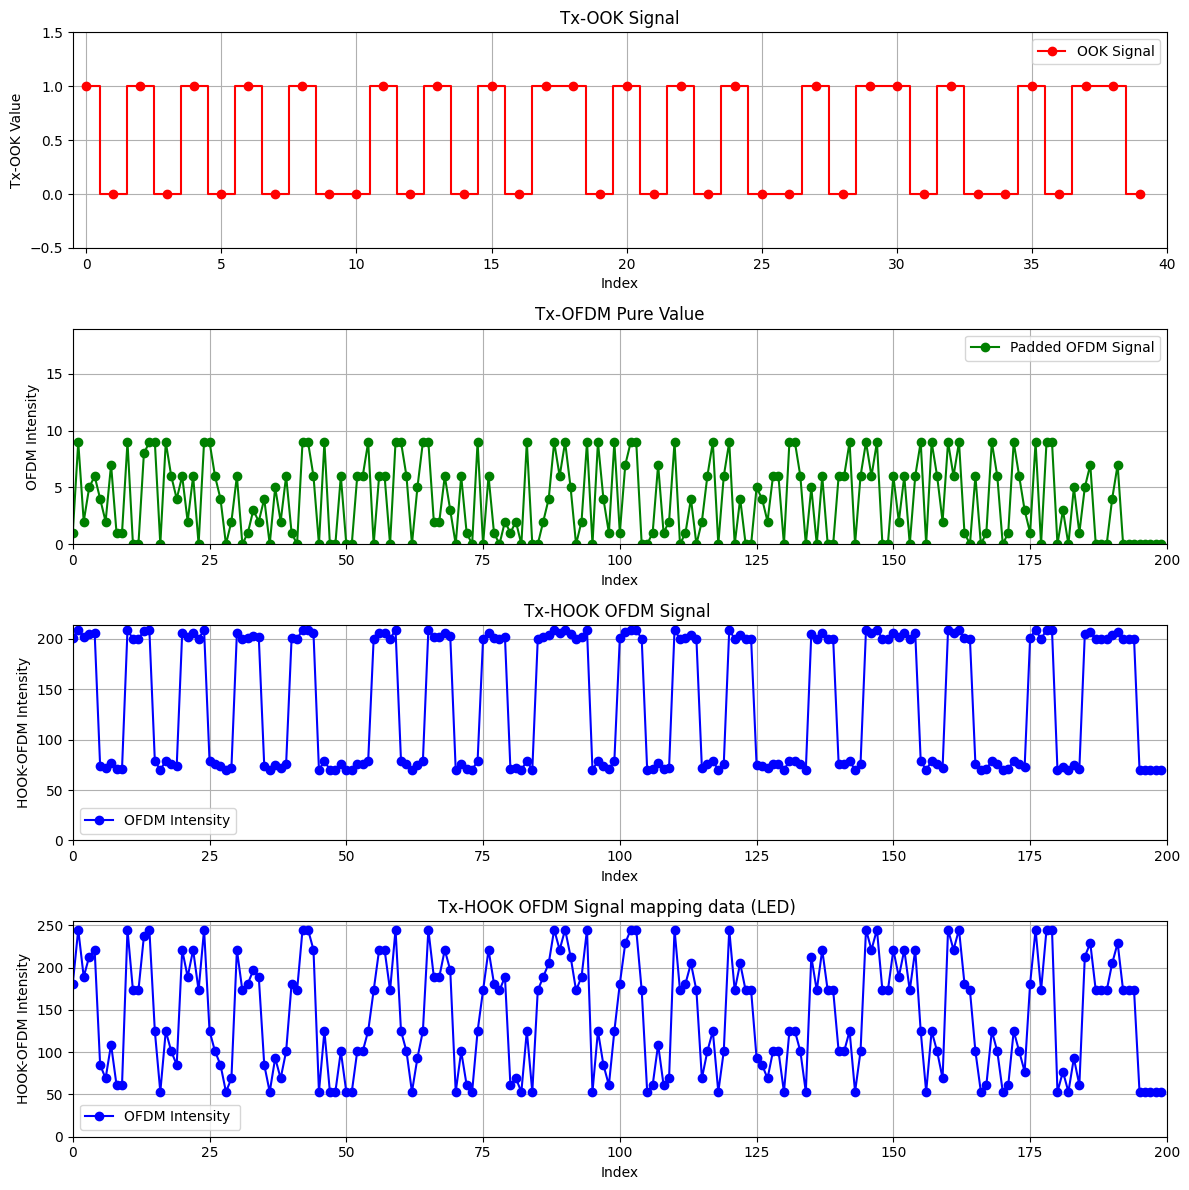

In [18]:
# #Plotting Data in 1st mapping
plt.figure(figsize=(12, 12))

# Subplot 1: OOK Signal
plt.subplot(4, 1, 1)
plt.step(range(len(OOK)), OOK, where='mid', linestyle='-', color='r', marker='o', label="OOK Signal")
plt.ylim(-0.5, 1.5)  # Limit y-axis to 0-1.5
plt.xlim(-0.5, len(OOK))  # Data range
plt.xlabel('Index')
plt.ylabel('Tx-OOK Value')
plt.title('Tx-OOK Signal')
plt.grid(True)
plt.legend()

# Subplot 2: Padded OFDM Signal
plt.subplot(4, 1, 2)
plt.plot(hello1, marker='o', linestyle='-', color='g', label="Padded OFDM Signal")
plt.ylim(0, max(hello1) + 10)  # Adjust y-axis range dynamically
plt.xlim(0, len(hello1))  # Data range
plt.xlabel('Index')
plt.ylabel('OFDM Intensity')
plt.title('Tx-OFDM Pure Value')
plt.grid(True)
plt.legend()

# Subplot 3: OFDM Intensity 1st mapping
plt.subplot(4, 1, 3)
plt.plot(combined_data, marker='o', linestyle='-', color='b', label="OFDM Intensity")
plt.ylim(0, max(combined_data) + 5)  # Intensity range
plt.xlim(0, len(combined_data))  # Data range
plt.xlabel('Index')
plt.ylabel('HOOK-OFDM Intensity')
plt.title('Tx-HOOK OFDM Signal ')
plt.grid(True)
plt.legend()

# Subplot 4: OFDM Intensity 2nd mapping (for real time implementation)
plt.subplot(4, 1, 4)
plt.plot(mapping_HOFDM, marker='o', linestyle='-', color='b', label="OFDM Intensity ")
plt.ylim(0, max(mapping_HOFDM) + 10)  # Intensity range
plt.xlim(0, len(mapping_HOFDM))  # Data range
plt.xlabel('Index')
plt.ylabel('HOOK-OFDM Intensity')
plt.title('Tx-HOOK OFDM Signal mapping data (LED) ')
plt.grid(True)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()